#**Classification homework**

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [17]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

df.head(10)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [19]:
df.describe(include='all', percentiles=[.25,.5,.75]).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
lead_source,1334,5,organic_search,282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
industry,1328,7,retail,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_courses_viewed,1462.0,NaN,NaN,NaN,2.031464,1.449717,0.0,1.0,2.0,3.0,9.0
annual_income,1281.0,NaN,NaN,NaN,59886.273224,15070.140389,13929.0,49698.0,60148.0,69639.0,109899.0
employment_status,1362,4,self_employed,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,1399,7,north_america,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interaction_count,1462.0,NaN,NaN,NaN,2.976744,1.681564,0.0,2.0,3.0,4.0,11.0
lead_score,1462.0,NaN,NaN,NaN,0.506108,0.288465,0.0,0.2625,0.51,0.75,1.0
converted,1462.0,NaN,NaN,NaN,0.619015,0.485795,0.0,0.0,1.0,1.0,1.0


###**Data preparation**
* Check if the missing values are presented in the features.
* If there are missing values:
  * For caterogiral features, replace them with 'NA'
  * For numerical features, replace with with 0.0

In [20]:
pd.DataFrame({
    'dtype': df.dtypes,
    'missing_count': df.isnull().sum(),
    'missing_%': (df.isnull().sum() / len(df) * 100).round(2)
})

,dtype,missing_count,missing_%
lead_source,object,128,8.76
industry,object,134,9.17
number_of_courses_viewed,int64,0,0.00
annual_income,float64,181,12.38
employment_status,object,100,6.84
location,object,63,4.31
interaction_count,int64,0,0.00
lead_score,float64,0,0.00
converted,int64,0,0.00


In [21]:
categorical_columns = list(df.select_dtypes(include=['object', 'category']).columns)
numerical_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

df[numerical_columns] = df[numerical_columns].fillna(0)
df[categorical_columns] = df[categorical_columns].fillna('NA').astype(str)

In [22]:
numerical_columns = [col for col in numerical_columns if col != 'converted']

###**<font color='red'>Question 1 </font>**
What is the most frequent observation (mode) for the column `industry`?

- NA
- technology
- healthcare
- <font color='green'>retail</font> ✅

In [23]:
df["industry"].mode()[0]

'retail'

###**<font color='red'>Question 2 </font>**
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?


- `interaction_count` and `lead_score`
- `number_of_courses_viewed` and `lead_score`
- `number_of_courses_viewed` and `interaction_count`
- <font color='green'>annual_income and interaction_count</font> ✅

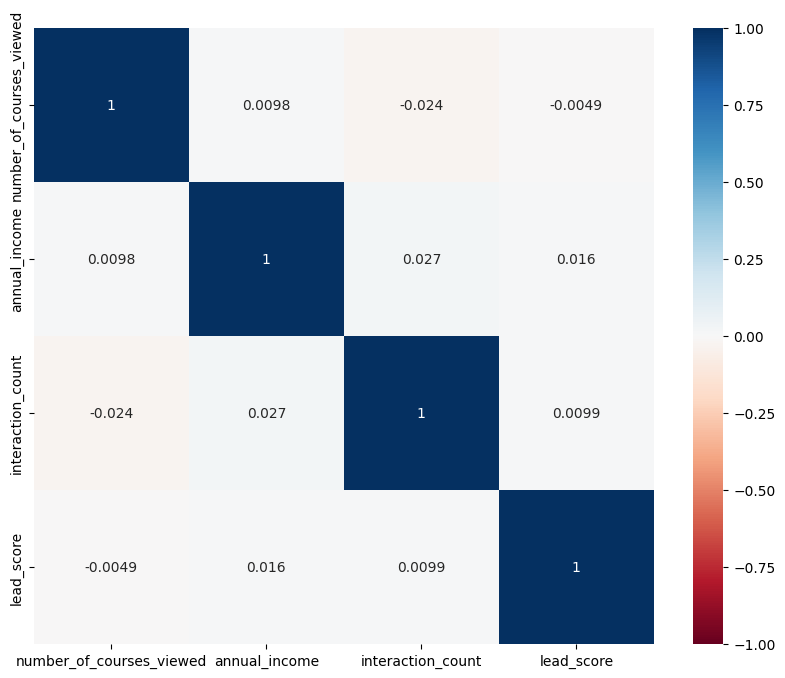

In [24]:
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    df[numerical_columns].corr(method="pearson"),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap=sns.color_palette("RdBu", as_cmap=True),
)

###Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
- Make sure that the target value `y` is not in your dataframe.

In [25]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [26]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

###**<font color='red'>Question 3</font>**
- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?

- industry
- location
- <font color='green'>lead_source</font> ✅
- employment_status

In [29]:
def mutual_info_converted_score(series):
    return round(mutual_info_score(series, df_full_train.converted), 2)

mi = df_full_train[categorical_columns].apply(mutual_info_converted_score)
mi.sort_values(ascending=False)

,0
lead_source,0.03
industry,0.01
employment_status,0.01
location,0.00


###**<font color='red'>Question 4</font>**
- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
  - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?
- 0.64
- <font color='green'>0.74</font> ✅
- 0.84
- 0.94

In [30]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [31]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [32]:
y_pred_class = model.predict(X_val)

In [33]:
accuracy_full = accuracy_score(y_val, y_pred_class)
round(accuracy_full, 2)

0.7

###**<font color='red'>Question 5</font>**
- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

- <font color='green'>'industry'</font> ✅
- 'employment_status'
- 'lead_score'

> Note: The difference doesn't have to be positive.







In [34]:
all_features = categorical_columns + numerical_columns
features = ['industry', 'employment_status', 'lead_score']
for f in features:
    reduced_feats = [x for x in all_features if x != f]

    dv = DictVectorizer(sparse=False)

    train_dict = df_train[reduced_feats].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[reduced_feats].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_class = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred_class)

    print(f"{f}: Δ = {accuracy_full - acc:.4f}")

industry: Δ = 0.0000
employment_status: Δ = 0.0034
lead_score: Δ = -0.0068


###**<font color='red'>Question 6</font>**
- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter `C`: `[0.01, 0.1, 1, 10, 100]`.
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these `C` leads to the best accuracy on the validation set?

- <font color='green'>0.01</font> ✅
- 0.1
- 1
- 10
- 100

> Note: If there are multiple options, select the smallest C.



In [35]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

results = []
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_class = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred_class)

    results.append({'C': C, 'accuracy': accuracy})
    print(f"C={C:<6}  accuracy={accuracy:.3f}")

C=0.01    accuracy=0.700
C=0.1     accuracy=0.700
C=1       accuracy=0.700
C=10      accuracy=0.700
C=100     accuracy=0.700
